***Здесь пример того, как будет реализованы преобразования входного изображения в изображение, с которым будет работать алгоритм распознавания.***

In [1]:
import numpy as np
import os  # для работы с операционной системой

import skimage  # библиотека работы с изображениями
import skimage.transform  # модуль для преобразования изображений
import skimage.io  # input-out изображений

from skimage import morphology  # морфологические преобразования
from skimage import exposure  # повышение контрастности
from scipy import ndimage  # для размытия изображения

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# директория обрабатываемых фотографий
files_dir = 'my_test_2'

# список доступных файлов
files_list = os.listdir(files_dir)
print('Доступны к обработке следующие файлы:\n')
for i, filename in enumerate(files_list):
    print(i, '. --- ' + filename, sep='')

Доступны к обработке следующие файлы:

0. --- alpha_big.jpg
1. --- alpha_mid.jpg
2. --- alpha_small.jpg


In [3]:
# список загруженных изображений
image_list = []
for filename in files_list:
    image_list.append(skimage.io.imread(files_dir + '/' + filename))

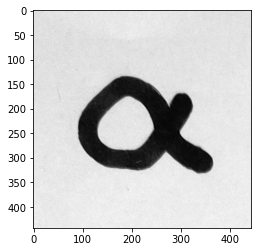

In [4]:
# на примере буквы №1
img = image_list[1]
img_0 = skimage.color.rgb2gray(img)  # преобразуем изображение в чб

# рисуем 
plt.imshow(img_0, cmap='gray')

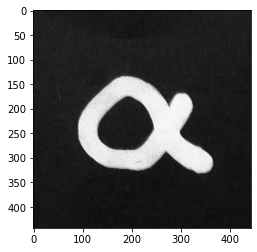

In [5]:
# инвертируем цвета
img_0_inverted = np.abs(img_0 - 1)

# рисуем 
plt.imshow(img_0_inverted, cmap='gray')

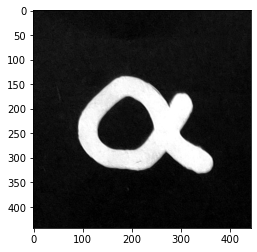

In [6]:
# увеличение контрастности
p2, p98 = np.percentile(img_0_inverted, (2, 98))
img_rescale = exposure.rescale_intensity(img_0_inverted, in_range=(p2, p98))

# рисуем 
plt.imshow(img_rescale, cmap='gray')

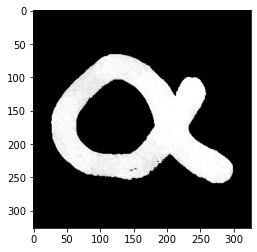

In [7]:
# маска на темные пиксели
thr = 0.8
img_precrop = img_rescale.copy()
img_precrop[img_rescale < thr] = 0.0

# ищем границы буквы
x_len, y_len = img_precrop.shape

for x_cord in range(x_len):
    if not all(img_precrop[:, x_cord].flatten() < thr):
        x_left = x_cord
        break

for x_cord in range(x_len - 1, x_left, -1):
    if not all(img_precrop[:, x_cord].flatten() < thr):
        x_right = x_cord
        break
        
for y_cord in range(y_len):
    if not all(img_precrop[y_cord, :].flatten() < thr):
        y_lower = y_cord
        break

for y_cord in range(y_len - 1, y_lower, -1):
    if not all(img_precrop[y_cord, :].flatten() < thr):
        y_upper = y_cord
        break

# ширина и высота буквы
width = x_right - x_left
height = y_upper - y_lower

# кадрирование
if width > height:
    indent = width // 10
    img_croped = np.zeros((width + 2 * indent, width + 2 * indent))
    img_croped[(indent + (width - height) // 2):((indent + (width - height) // 2) + height),
               indent:(indent + width), ] = img_precrop[y_lower:y_upper, x_left:x_right]
else:
    indent = height // 10
    img_croped = np.zeros((height + 2 * indent, height + 2 * indent))
    img_croped[indent:(indent + height),
               (indent + (height - width) // 2):((indent + (height - width) // 2) + width)] = img_precrop[y_lower:y_upper, 
                                                                                                        x_left:x_right]

# рисуем 
plt.imshow(img_croped, cmap='gray')

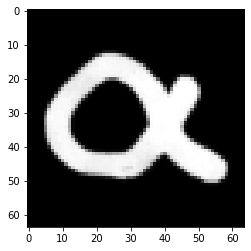

In [8]:
# приведение к заданному размеру
img_1 = skimage.transform.resize(img_croped, (64, 64))

# рисуем 
plt.imshow(img_1, cmap='gray')

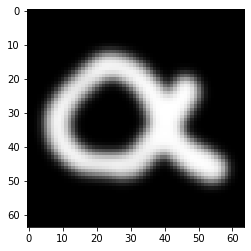

In [9]:
# размываем, чтобы убрать неровности изображения
img_2 = ndimage.gaussian_filter(img_1, sigma=1.5)

# рисуем 
plt.imshow(img_2, cmap='gray')

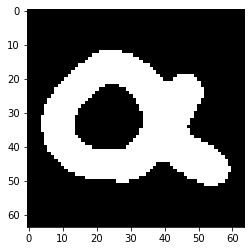

In [10]:
# бинаризуем
img_3 = img_2.copy()
img_3[img_2 < img_2.mean()] = 0
img_3[img_2 >= img_2.mean()] = 1

# рисуем 
plt.imshow(img_3, cmap='gray')

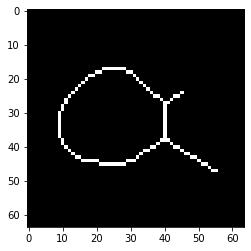

In [11]:
# выделяем скелет
img_4 = morphology.skeletonize(img_3)

# рисуем 
plt.imshow(img_4, cmap='gray')

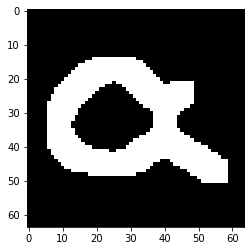

In [12]:
# делаем линии толще для корректной работы метода
img_5 = morphology.dilation(img_4, selem=np.ones((7, 7)))

# рисуем 
plt.imshow(img_5, cmap='gray')